<a href="https://colab.research.google.com/github/nahu9815/inteligencia_artificial/blob/main/CHEST_XRAY_20_epoch_modelo_VGG16%20ejemplo%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
import os
import numpy as np # Linear Algebra
import matplotlib.pyplot as plt # Visualization
import matplotlib.image as implt # Visualization
import seaborn as sns # Visualization


# For Network
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras import Model
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import datetime
from sklearn.metrics import confusion_matrix

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
BATCH_SIZE = 64
EPOCHS = 20

TRAIN_PATH = '/content/drive/MyDrive/INTELIGENCIA_ARTIFICIAL_GRUPO/chest_xray/train/'
TEST_PATH = '/content/drive/MyDrive/INTELIGENCIA_ARTIFICIAL_GRUPO/chest_xray/test/'

TRAIN_NORMAL = os.listdir(TRAIN_PATH + '/NORMAL')
TRAIN_PNEUMONIA = os.listdir(TRAIN_PATH + '/PNEUMONIA')

TEST_NORMAL = os.listdir(TEST_PATH + '/NORMAL')
TEST_PNEUMONIA = os.listdir(TEST_PATH + '/PNEUMONIA')


TARGET_SIZE = (300, 300)
GREY = (3,)
INPUT_SIZE = TARGET_SIZE + GREY

CLASSES = ['Normal','Pneumonia']
if (os.path.exists(TRAIN_PATH) and os.path.exists(TEST_PATH)):
    print('OK')
else:
    print('No existen carpetas')

OK


In [69]:
num_train_normal = len(TRAIN_NORMAL)
num_train_pneumonia = len(TRAIN_PNEUMONIA)
num_train = num_train_normal + num_train_pneumonia 

num_test_normal = len(TEST_NORMAL)
num_test_pneumonia = len(TEST_PNEUMONIA)
num_test = num_test_normal + num_test_pneumonia

num_all = num_train + num_test

print('Normal images in train-set: ', num_train_normal) 
print('Pneumonia images in train-set: ', num_train_pneumonia)
print('Total images in train-set: ', num_train,'--->', round(num_train/num_all,3)*100, 'Percent')

print("\nNormal images in test-set:", num_test_normal)
print("Pneumonia images in test-set:", num_test_pneumonia)
print('Total images in test-set: ', num_test, '--->', round(num_test/num_all,3)*100, 'Percent')

print('\nAll the images in Dataset: ', num_all)

Normal images in train-set:  1349
Pneumonia images in train-set:  3883
Total images in train-set:  5232 ---> 89.3 Percent

Normal images in test-set: 234
Pneumonia images in test-set: 390
Total images in test-set:  624 ---> 10.7 Percent

All the images in Dataset:  5856


In [70]:
train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255,
                                   rotation_range=5, # Randomly rotate my image between 0 and 5 degrees.
                                   width_shift_range=0.1, # Horizontal shift.
                                   height_shift_range=0.1, # Vertical shift.
                                   zoom_range=0.1, # Zoom.
                                   horizontal_flip=True, # Randomly flip inputs horizontally.
                                   samplewise_center=True, # Set each sample mean to 0. 
                                   samplewise_std_normalization=True) # Divide each input by its std.
                                   
train_generator = train_datagen.flow_from_directory(directory=TRAIN_PATH, batch_size=BATCH_SIZE, class_mode='categorical', target_size=TARGET_SIZE, subset='training')

validation_generator = train_datagen.flow_from_directory(directory=TRAIN_PATH, batch_size=BATCH_SIZE, class_mode='categorical', target_size=TARGET_SIZE, subset='validation')

image_train, label_train = train_generator.next()




# Validation\Test should not be augmented.
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(directory=TEST_PATH, batch_size = BATCH_SIZE, class_mode='categorical', target_size=TARGET_SIZE, shuffle=True)

image_test, label_test = test_generator.next()

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

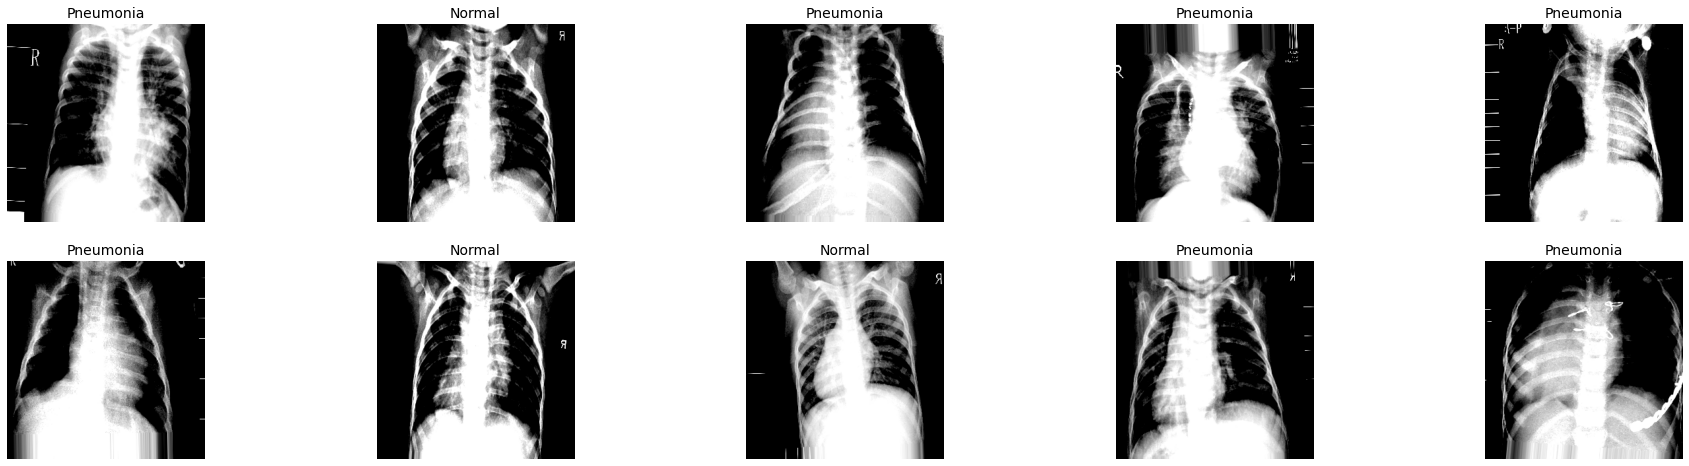

In [71]:
def show_tarin(batch_size, images, labels):
    
    images = images[0:batch_size,:,:,:]
    labels = labels[0:batch_size,:]
    
    image_rows = 2
    image_col = int(batch_size/image_rows)
    
    _, axs = plt.subplots(image_rows, image_col, figsize=(32,8))
    axs = axs.flatten()
    
    for i in range(batch_size):
        img = images[i,:,:,:]
        lab = labels[i,:]
        axs[i].imshow(img)
        axs[i].axis('off')
        lab = np.argmax(lab)
        axs[i].set_title(label = CLASSES[lab], fontsize=14)

    plt.show()
    
    
show_tarin(10, image_train, label_train)

In [72]:
def craete_model():
    
    # Load vgg16 model without the top layer
    model = VGG16(include_top=False, weights='imagenet',input_shape=INPUT_SIZE)

    # Freeze
    model.trainable = False
    
    # New classifier layers
    flatten = Flatten()(model.layers[-1].output) # Flatt last vgg16 layer (except the last).
    fc1 = Dense(units=512, activation='relu')(flatten)
    dropout = Dropout(0.05)(fc1)
    output = Dense(2, activation='softmax')(dropout)
   
    # Define a new Model
    model = Model(inputs=model.input, outputs=output)
    
    # Summary
    model.summary()
    
    return model


model = craete_model()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0   

In [73]:
opt = optimizers.Nadam(learning_rate=0.00001)
loss = CategoricalCrossentropy()
met = 'accuracy'

# Compile the Model
model.compile(optimizer=opt, loss=loss, metrics=[met])

In [74]:
# For TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%d%m%Y-%H%M%S")

my_callbacks = [EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=5, mode='auto',restore_best_weights=False, verbose=1),

                ModelCheckpoint(filepath='my_model.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch', verbose=1),

                TensorBoard(log_dir=log_dir, histogram_freq=1) ]

In [75]:
history = model.fit(train_generator, # If x is a dataset -> y should not be specified (since targets will be obtained from x).
                    epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=validation_generator,
                    callbacks=[my_callbacks],
                    steps_per_epoch=3,
                    verbose=1)

print('\n*** Fit is over ***')
model.save('my_model.h5')

Epoch 1/20
3/3 [==============================] - 38s 17s/step - loss: 0.5670 - accuracy: 0.7708 - val_loss: 0.5254 - val_accuracy: 0.7426

Epoch 00001: val_accuracy improved from -inf to 0.74258, saving model to my_model.h5
Epoch 2/20
3/3 [==============================] - 35s 16s/step - loss: 0.4970 - accuracy: 0.7656 - val_loss: 0.4688 - val_accuracy: 0.7809

Epoch 00002: val_accuracy improved from 0.74258 to 0.78086, saving model to my_model.h5
Epoch 3/20
3/3 [==============================] - 35s 17s/step - loss: 0.4987 - accuracy: 0.7604 - val_loss: 0.4100 - val_accuracy: 0.7799

Epoch 00003: val_accuracy did not improve from 0.78086
Epoch 4/20
3/3 [==============================] - 35s 16s/step - loss: 0.3929 - accuracy: 0.8073 - val_loss: 0.3639 - val_accuracy: 0.8201

Epoch 00004: val_accuracy improved from 0.78086 to 0.82010, saving model to my_model.h5
Epoch 5/20
3/3 [==============================] - 35s 16s/step - loss: 0.2864 - accuracy: 0.8906 - val_loss: 0.3777 - val_ac

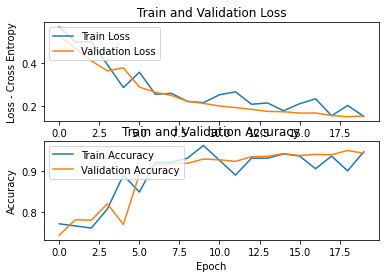

In [76]:
def graphs_learning_display(history):
    
    # Train and Test Loss
    plt.subplot(2,1,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper left')
    plt.xlabel('Epoch')
    plt.ylabel('Loss - Cross Entropy')
    plt.title('Train and Validation Loss')
    
    # Train and Test Accuracy
    plt.subplot(2,1,2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='upper left')
    plt.xlabel('Epoch'),
    plt.ylabel('Accuracy')
    plt.title('Train and Validation Accuracy')
    
    plt.show()
    

graphs_learning_display(history)

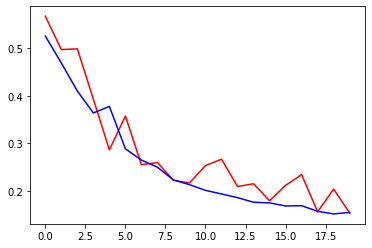

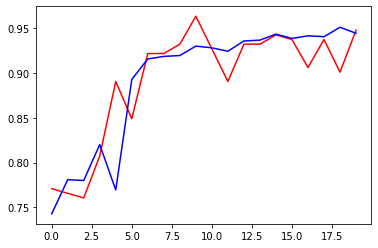

In [77]:
history.history
plt.plot(range(len(history.history['loss'])), history.history['loss'], color='red')
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], color='blue')

plt.show()
history.history
plt.plot(range(len(history.history['accuracy'])), history.history['accuracy'], color='red')
plt.plot(range(len(history.history['val_accuracy'])), history.history['val_accuracy'], color='blue')

plt.show()

In [78]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
test_loss = round(test_loss, 6)
test_accuracy = round(test_accuracy*100, 3)

print('Test Loss: ', test_loss)
print('Test Accuracy:', '\033[0m', test_accuracy, '%\033[0m')

Test Loss:  1.551522
Test Accuracy:  62.5 %


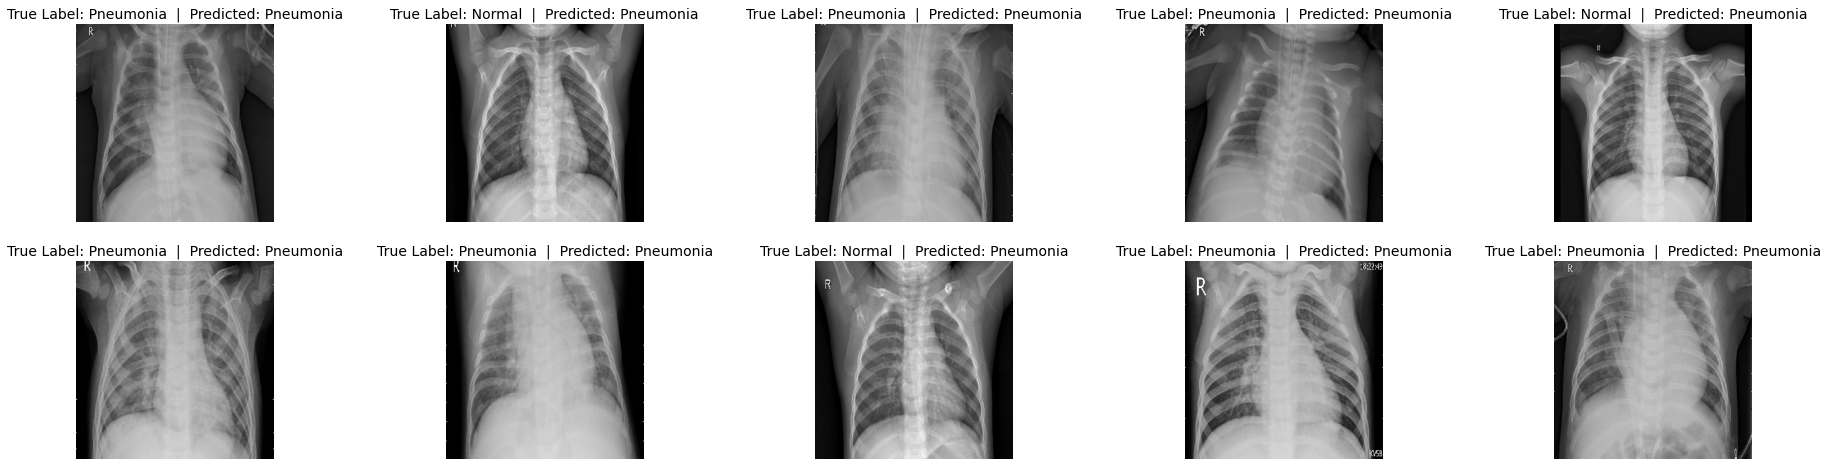

In [79]:
def show(model, batch_size, images, labels):
    
    images = images[0:batch_size,:,:,:]
    labels = labels[0:batch_size,:]
    predict = np.round(model.predict(images))
    
    image_rows = 2
    image_col = int(batch_size/image_rows)
    
    _, axs = plt.subplots(image_rows, image_col, figsize=(32,8))
    axs = axs.flatten()
    
    for i in range(batch_size):
        img = images[i,:,:,:]
        lab = labels[i,:]
        axs[i].imshow(img)
        pred = predict[i]
        axs[i].axis('off')
        lab, pred = np.argmax(lab), np.argmax(pred)
        axs[i].set_title(label = f'True Label: {CLASSES[lab]}  |  Predicted: {CLASSES[pred]}', fontsize=14)

    plt.show()
    
    
show(model, 10, image_test, label_test)

Text(0.5, 1.0, 'Confusion Matrix')

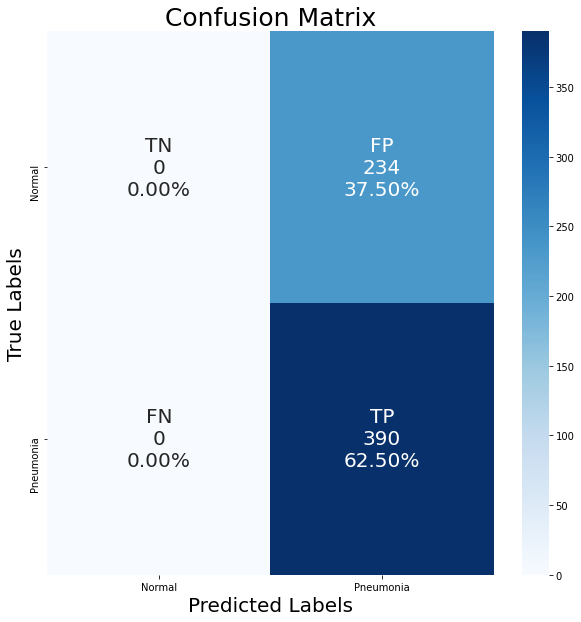

In [80]:
y_pred = model.predict(test_generator).argmax(axis=-1)

conf_mat = confusion_matrix(test_generator.classes, y_pred)


group_names = ['TN','FP','FN','TP']
group_counts = ['{0:0.0f}'.format(value) for value in conf_mat.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in conf_mat.flatten()/np.sum(conf_mat)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, xticklabels=CLASSES, yticklabels=CLASSES, ax=ax, annot=labels, fmt='', cbar=True, annot_kws={'size': 20}, cmap='Blues')
ax.set_xlabel('Predicted Labels', fontsize=20)
ax.set_ylabel('True Labels', fontsize=20)
plt.title('Confusion Matrix', fontsize=25)

In [81]:
train_acc = round(np.max(history.history['accuracy'])*100, 2)
valid_acc = round(np.max(history.history['val_accuracy'])*100,2)

print('Training Accuracy:','\033[0m', train_acc, '%\033[0m')
print('Validation Accuracy:','\033[0m', valid_acc, '%\033[0m')
print('Test Accuracy:', '\033[0m', test_accuracy,'%\033[0m')

Training Accuracy:  96.35 %
Validation Accuracy:  95.12 %
Test Accuracy:  62.5 %


In [82]:
from keras.models import load_model

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('my_model.h5')

In [83]:
from tensorflow.keras.models import load_model

In [84]:
from keras.preprocessing import image